In [19]:
# 导入必要的库
import sys
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from pathlib import Path

# 添加项目根目录到系统路径
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# 导入项目相关模块
from core.molecule_processor import MoleculeProcessor
from core.gaussian_calculator import GaussianCalculator
from visualization.plot_manager import PlotManager

# some calculations for wang's paper
base_list = [
'C(F)(F)(F)C(F)(F)C(F)(F)C(F)(F)(OC(F)(F)(F))',
'C1(=O)N(CC=C)C2C(N(CC=C)C(=O)N2(CC=C))N1(CC=C)',
'C1(=O)N(CC=C)C(=O)N(CC=C)C(=O)N1(CC=C)',
'C1(=O)N(CC=C)C(=O)N(CC=C)C(=O)N1(C)',
'C1(=O)N(CC=C)C(=O)N(CC=C)C(=O)N1(CCN2C(=O)N(CC=C)C(=O)N(CC=C)C2(=O))',
]
name_list = ['FFKM','TAG','TAIC','LDAI1C','D2D']
set_name = 'wang5'
iteration = 3
calculator_params = {
    'parent_dir': set_name,
    'method': 'CAM-B3LYP',  # DFT泛函
    'basis': '6-31G(d,p)',  # 基组
    'opt': False,  # 进行结构优化
    'dispersion': False,  # 包含色散校正
    'polar': False,  # 不计算极化率
    'volume': False,  # 不计算体积
    'pcm': True,  # 不使用PCM溶剂化模型
    'eps': 4.9,  # PCM模型的介电常数
    'wfn': True,  # 输出波函数文件
    'debug': False  # 非调试模式
}



In [20]:
# 使用PlotManager绘制分子结构
PlotManager.plot_molecules(
    smiles_list=base_list,
    name_list=name_list,
    parent_dir=set_name,
    save_path='molecular_structures.pdf',
    cols=5,  # 每行显示4个分子
    with_timestamp=False
)
# FFKM分子构建和交联反应参数
direction = 'L'
m = 1
n = 0
c = 3

# 进行FFKM分子构建和交联反应
FFKM_list = []
for base_mol in base_list:
    # 构建FFKM分子
    ffkm, connection_point = MoleculeProcessor.build_ffkm(
        m=m,
        n=n,
        c=c,
        connection_direction=direction
    )
    
    # 模拟交联反应
    crossed_mol = MoleculeProcessor.simulate_crosslink_reaction(
        base=base_mol,
        ffkm=ffkm,
        connection_point=connection_point
    )
    
    FFKM_list.append(crossed_mol)

# 绘制交联反应后的分子结构
PlotManager.plot_molecules(
    smiles_list=FFKM_list,
    name_list=name_list,
    save_path='crosslinked_molecules.pdf',
    parent_dir=set_name,
    cols=5,  # 每行显示4个分子
    with_timestamp=False
)


In [21]:
# ... earlier code remains the same ...

# 为每个FFKM分子生成多个xyz文件
for i, (mol_smiles, mol_name) in enumerate(zip(FFKM_list, name_list)):
    success_count = 0
    attempt = 0
    max_attempts = 20  # 最大尝试次数，防止无限循环
    
    while success_count < iteration and attempt < max_attempts:
        try:
            current_seed = 42 + attempt
            
            # 修改文件命名格式，使用 init 作为后缀
            xyz_filename = f"{mol_name}{success_count}_init.xyz"
            
            MoleculeProcessor.smile2xyz(
                xyz_name=xyz_filename,
                smile=mol_smiles,
                randomSeed=current_seed,
                parent_dir=set_name
            )
            
            success_count += 1
            # print(f"成功生成 {mol_name} 的第 {success_count} 个初始构象")
            
        except Exception as e:
            print(f"尝试生成 {mol_name} 第 {success_count + 1} 个构象时失败: {e}")
        
        attempt += 1
    
    if success_count < iteration:
        print(f"警告: {mol_name} 只成功生成了 {success_count} 个构象")

尝试生成 TAG 第 1 个构象时失败: XYZ文件生成失败: Bad Conformer Id
尝试生成 TAG 第 3 个构象时失败: XYZ文件生成失败: Bad Conformer Id


In [22]:
# 为每个分子准备高斯计算文件
for name in name_list:
    try:
        # 创建分子目录
        mol_dir = Path('examples') / name
        mol_dir.mkdir(parents=True, exist_ok=True)
        
        # 为每个构象准备2种电荷态的计算文件
        for conf_id in range(iteration):
            xyz_file = f"{name}{conf_id}_init.xyz"
            
            # 准备中性态计算文件
            neutral_calc = GaussianCalculator(**calculator_params, charge='neu')
            neutral_calc._prepare_calculation(xyz_file)
            neutral_calc._generate_input_file()
            neutral_calc._generate_shell_script()
            neutral_calc._submit_job()
            
            
            # 准备阳离子态计算文件（用于IP计算）
            cation_calc = GaussianCalculator(**calculator_params, charge='pos')
            cation_calc._prepare_calculation(xyz_file)
            cation_calc._generate_input_file()
            cation_calc._generate_shell_script()
            cation_calc._submit_job()
            
        print(f"成功为{name}准备所有计算文件")
        
    except Exception as e:
        print(f"处理{name}时出错: {str(e)}")

成功为FFKM准备所有计算文件
成功为TAG准备所有计算文件
成功为TAIC准备所有计算文件
成功为LDAI1C准备所有计算文件
成功为D2D准备所有计算文件


sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found
sh: sbatch: command not found


正在计算IP值...


100%|██████████| 4/4 [00:00<00:00, 5363.56it/s]

Error: [Errno 2] No such file or directory: 'finalDD2/finalDD2_0.log'
Error: [Errno 2] No such file or directory: 'finalLDAIC1/finalLDAIC1_0.log'
Error: [Errno 2] No such file or directory: 'finalTAG/finalTAG_0.log'
Error: [Errno 2] No such file or directory: 'finalTAIC/finalTAIC_0.log'

清理数据中的异常值...

IP计算结果（单位：eV）:
分子顺序: ['finalDD2', 'finalLDAIC1', 'finalTAG', 'finalTAIC']
IP值:
 [[nan nan nan nan]]

各分子的IP统计分析:



/Users/yuhangu/Desktop/electret_cal/data/data_processor.py:147: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.fillna(df.mean())


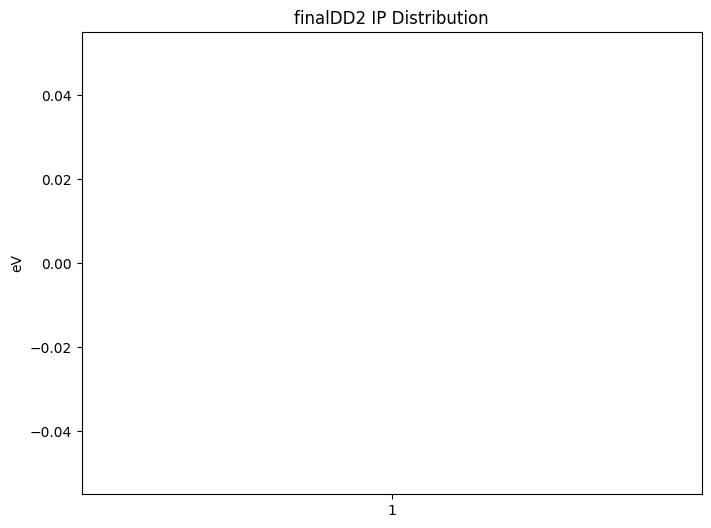

/opt/anaconda3/envs/integrated/lib/python3.9/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


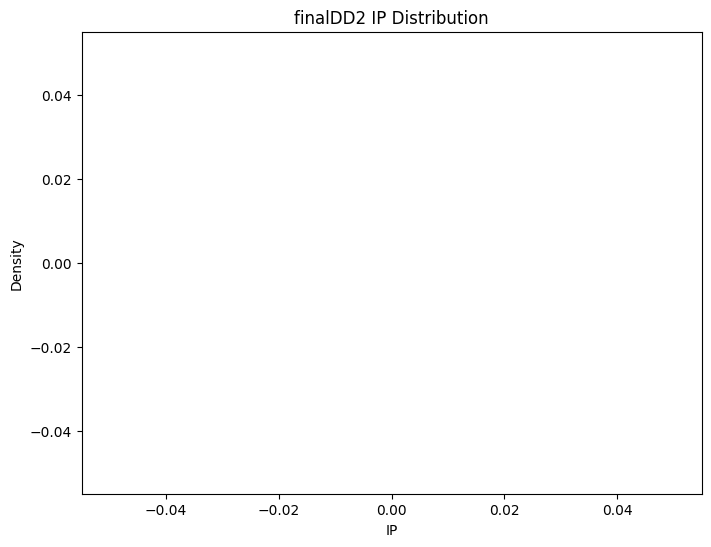


finalDD2 IP Statistics:
Number of valid samples: 0


/opt/anaconda3/envs/integrated/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/integrated/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

In [5]:
from data.data_processor import DataProcessor
from tqdm import tqdm
# 定义要分析的分子名称列表
molecule_names = ['finalDD2', 'finalLDAIC1', 'finalTAG', 'finalTAIC']

# 设置迭代次数
iterations = 1

# 使用DataProcessor创建IP属性的数据框
print("正在计算IP值...")
ip_df = DataProcessor.create_property_dataframe(molecule_names, iterations, 'IP')

# 清理数据中的异常值
print("\n清理数据中的异常值...")
clean_ip_df = DataProcessor.clean_data(ip_df)

# 转换为numpy数组并保存结果
ip_array = clean_ip_df.to_numpy()
print("\nIP计算结果（单位：eV）:")
print("分子顺序:", molecule_names)
print("IP值:\n", ip_array)

# 计算每个分子的统计值并生成可视化
print("\n各分子的IP统计分析:")
for i, molecule in enumerate(molecule_names):
    values = ip_array[:, i]
    median, mean = DataProcessor.analyze_property(values.tolist(), molecule, 'IP')